In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import os

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Проверка, существует ли уже файл cleaned_data.csv
if os.path.exists('cleaned_data.csv'):
    logging.info("Файл 'cleaned_data.csv' уже существует. Пропуск EDA.")
else:
    # Загрузка данных
    data = pd.read_csv('Sample - Superstore.csv', encoding='windows-1252')
    logging.info("Данные успешно загружены.")

    # Проверка на пропуски
    logging.info("Проверка на пропущенные значения:")
    logging.info(data.isnull().sum())

    # Корреляционная матрица для числовых признаков
    numeric_data = data.select_dtypes(include=['float64', 'int64'])
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
    plt.title('Корреляционная матрица')
    plt.show()

    # Анализ дублирующих признаков
    logging.info("Анализ дублирующих признаков:")
    logging.info(data[['City', 'Postal Code']].head(10))

    # Удаление лишних признаков
    data = data.drop(['Postal Code', 'Row ID', 'Order ID', 'Customer ID', 'Customer Name'], axis=1)
    logging.info("Лишние признаки удалены.")

    # Сохранение очищенных данных
    data.to_csv('cleaned_data.csv', index=False)
    logging.info("Очищенные данные сохранены в файл 'cleaned_data.csv'.")

2025-03-06 21:44:04,920 - INFO - Файл 'cleaned_data.csv' уже существует. Пропуск EDA.


In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка очищенных данных
data = pd.read_csv('cleaned_data.csv')
logging.info("Очищенные данные успешно загружены.")

# Выбор ключевых признаков
selected_features = ['Sales', 'Quantity', 'Discount', 'Category', 'Sub-Category', 'Region', 'Ship Mode']
X = data[selected_features]
y = data['Profit']

# Категориальные и числовые признаки
categorical_features = ['Category', 'Sub-Category', 'Region', 'Ship Mode']
numeric_features = ['Sales', 'Quantity', 'Discount']

# Создание пайплайна для предобработки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Применение предобработки
X_preprocessed = preprocessor.fit_transform(X)
logging.info("Данные успешно предобработаны.")

# Сохранение предобработанных данных
joblib.dump({'X': X_preprocessed, 'y': y}, 'preprocessed_data.joblib')
logging.info("Предобработанные данные сохранены в файл 'preprocessed_data.joblib'.")

# Сохранение ColumnTransformer для получения имен признаков
joblib.dump(preprocessor, 'preprocessor.joblib')
logging.info("ColumnTransformer сохранен в файл 'preprocessor.joblib'.")

# Получение имен признаков
feature_names = preprocessor.get_feature_names_out()

# Сохранение имен признаков в отдельный файл
joblib.dump(feature_names, 'feature_names.joblib')
logging.info("Имена признаков сохранены в файл 'feature_names.joblib'.")

2025-03-06 21:45:29,528 - INFO - Очищенные данные успешно загружены.
2025-03-06 21:45:29,554 - INFO - Данные успешно предобработаны.
2025-03-06 21:45:29,558 - INFO - Предобработанные данные сохранены в файл 'preprocessed_data.joblib'.
2025-03-06 21:45:29,561 - INFO - ColumnTransformer сохранен в файл 'preprocessor.joblib'.
2025-03-06 21:45:29,564 - INFO - Имена признаков сохранены в файл 'feature_names.joblib'.


In [3]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
import joblib
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка предобработанных данных
data = joblib.load('preprocessed_data.joblib')
X = data['X']
y = data['y']

# Функция для оптимизации RandomForest
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    score = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    return score

# Функция для оптимизации CatBoost
def objective_catboost(trial):
    iterations = trial.suggest_int('iterations', 500, 1500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    depth = trial.suggest_int('depth', 4, 8)
    model = CatBoostRegressor(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0, random_state=42)
    score = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    return score

# Оптимизация для RandomForest
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=20)

# Оптимизация для CatBoost
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=20)

# Сохранение лучших параметров
best_params_rf = study_rf.best_params
best_params_catboost = study_catboost.best_params

joblib.dump(best_params_rf, 'best_params_rf.joblib')
joblib.dump(best_params_catboost, 'best_params_catboost.joblib')

logging.info(f"Лучшие параметры для RandomForest: {best_params_rf}")
logging.info(f"Лучшие параметры для CatBoost: {best_params_catboost}")
logging.info("Лучшие параметры сохранены в файлы 'best_params_rf.joblib' и 'best_params_catboost.joblib'.")

[I 2025-03-06 21:46:53,266] A new study created in memory with name: no-name-88f7b6f5-a461-43d3-8453-a311020497ac
[I 2025-03-06 21:47:38,341] Trial 0 finished with value: 31.426893050495096 and parameters: {'n_estimators': 437, 'max_depth': 6}. Best is trial 0 with value: 31.426893050495096.
[I 2025-03-06 21:48:58,966] Trial 1 finished with value: 24.743196769093906 and parameters: {'n_estimators': 494, 'max_depth': 8}. Best is trial 1 with value: 24.743196769093906.
[I 2025-03-06 21:49:51,449] Trial 2 finished with value: 27.2417564690696 and parameters: {'n_estimators': 399, 'max_depth': 7}. Best is trial 1 with value: 24.743196769093906.
[I 2025-03-06 21:50:44,558] Trial 3 finished with value: 27.24249795467832 and parameters: {'n_estimators': 424, 'max_depth': 7}. Best is trial 1 with value: 24.743196769093906.
[I 2025-03-06 21:51:39,741] Trial 4 finished with value: 24.74318647931533 and parameters: {'n_estimators': 331, 'max_depth': 8}. Best is trial 4 with value: 24.743186479315

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib
import logging
import numpy as np
import pandas as pd

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка данных
data = joblib.load('preprocessed_data.joblib')
X, y = data['X'], data['y']

# Загрузка гиперпараметров
best_params_rf = joblib.load('best_params_rf.joblib')
best_params_catboost = joblib.load('best_params_catboost.joblib')

# Инициализация моделей
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(**best_params_rf, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(**best_params_catboost, verbose=0, random_state=42)
}

# Обучение и оценка
results = {}
for model_name, model in models.items():
    logging.info(f"Обучение модели: {model_name}...")
    
    # Кросс-валидация
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()
    
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Метрики
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    results[model_name] = {
        "CV MAE": round(cv_mae, 4),
        "MAE": round(mae, 4),
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "R²": round(r2, 4)
    }
    
    # Сохранение модели
    joblib.dump(model, f'{model_name.replace(" ", "_").lower()}_model.joblib')
    logging.info(f"Модель {model_name} сохранена.")

# Сохранение метрик
joblib.dump(results, 'model_results.joblib')

# Определение лучшей модели
best_model_name = max(results, key=lambda k: results[k]['R²'])
best_model = models[best_model_name]
joblib.dump(best_model, 'best_model.joblib')
logging.info(f"Лучшая модель: {best_model_name} (R²={results[best_model_name]['R²']})")

# Вывод метрик на экран
print("\nСравнение моделей по метрикам:")
metrics_df = pd.DataFrame(results).T
print(metrics_df)

2025-03-06 23:08:06,986 - INFO - Обучение модели: Linear Regression...
2025-03-06 23:08:07,028 - INFO - Модель Linear Regression сохранена.
2025-03-06 23:08:07,028 - INFO - Обучение модели: Random Forest...
2025-03-06 23:08:48,241 - INFO - Модель Random Forest сохранена.
2025-03-06 23:08:48,241 - INFO - Обучение модели: Gradient Boosting...
2025-03-06 23:08:51,642 - INFO - Модель Gradient Boosting сохранена.
2025-03-06 23:08:51,643 - INFO - Обучение модели: XGBoost...
2025-03-06 23:08:52,078 - INFO - Модель XGBoost сохранена.
2025-03-06 23:08:52,079 - INFO - Обучение модели: CatBoost...
2025-03-06 23:09:07,920 - INFO - Модель CatBoost сохранена.
2025-03-06 23:09:07,925 - INFO - Лучшая модель: XGBoost (R²=0.9951)



Сравнение моделей по метрикам:
                    CV MAE      MAE         MSE      RMSE      R²
Linear Regression  60.1416  59.2274  36439.9148  190.8924  0.3359
Random Forest      21.6801  14.7782   2825.8292   53.1585  0.9485
Gradient Boosting  27.6715  22.4931   2297.0717   47.9278  0.9581
XGBoost            19.4879   7.6276    266.9275   16.3379  0.9951
CatBoost           18.3687   7.9137    287.7738   16.9639  0.9948


2025-03-06 22:15:44,124 - INFO - Лучшая модель успешно загружена.
2025-03-06 22:15:44,129 - INFO - Имена признаков успешно загружены.


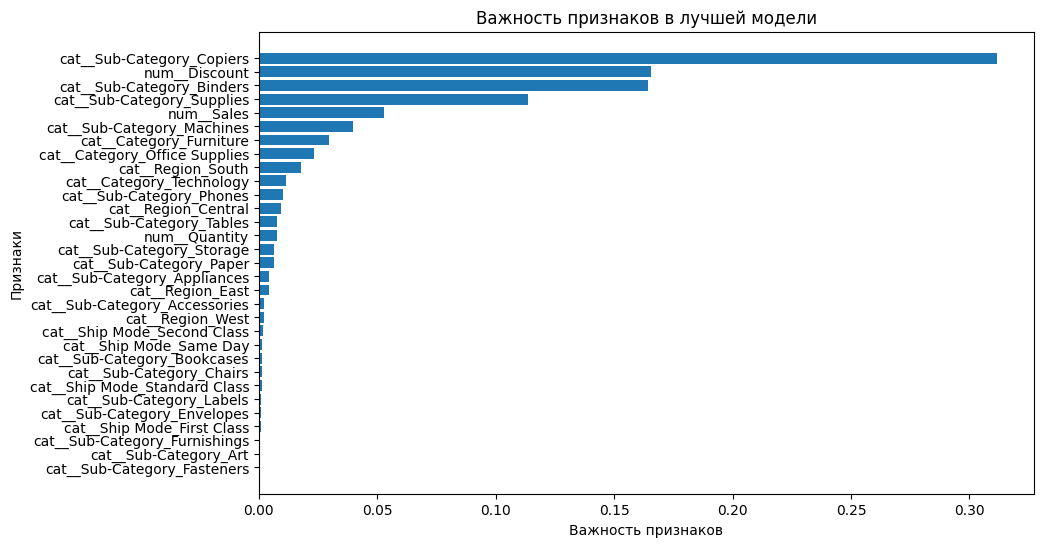

2025-03-06 22:15:44,626 - INFO - График важности признаков построен.


In [6]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка лучшей модели
best_model = joblib.load('best_model.joblib')
logging.info("Лучшая модель успешно загружена.")

# Загрузка имен признаков
feature_names = joblib.load('feature_names.joblib')
logging.info("Имена признаков успешно загружены.")

# Получение важности признаков
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
else:
    logging.warning("Модель не поддерживает атрибут feature_importances_.")
    feature_importance = None

if feature_importance is not None:
    # Сортировка признаков по важности
    sorted_idx = np.argsort(feature_importance)
    sorted_feature_names = [feature_names[i] for i in sorted_idx]
    sorted_importance = feature_importance[sorted_idx]

    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
    plt.yticks(range(len(sorted_importance)), sorted_feature_names)
    plt.xlabel('Важность признаков')
    plt.ylabel('Признаки')
    plt.title('Важность признаков в лучшей модели')
    plt.show()
    logging.info("График важности признаков построен.")
else:
    logging.info("Визуализация важности признаков недоступна для этой модели.")

2025-03-06 22:15:44,683 - INFO - Данные и метрики успешно загружены.
2025-03-06 22:15:44,686 - INFO - Построение отдельных графиков для каждой модели...


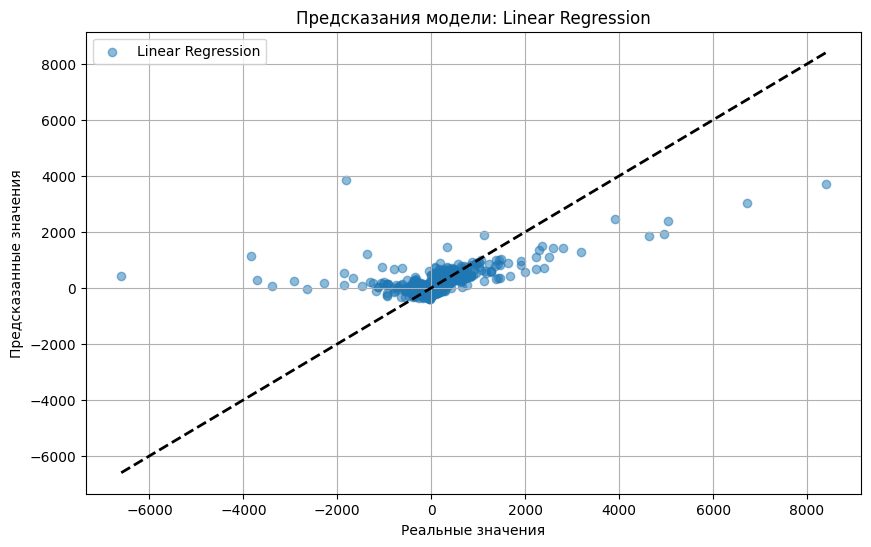

2025-03-06 22:15:47,136 - INFO - График для Linear Regression сохранен.


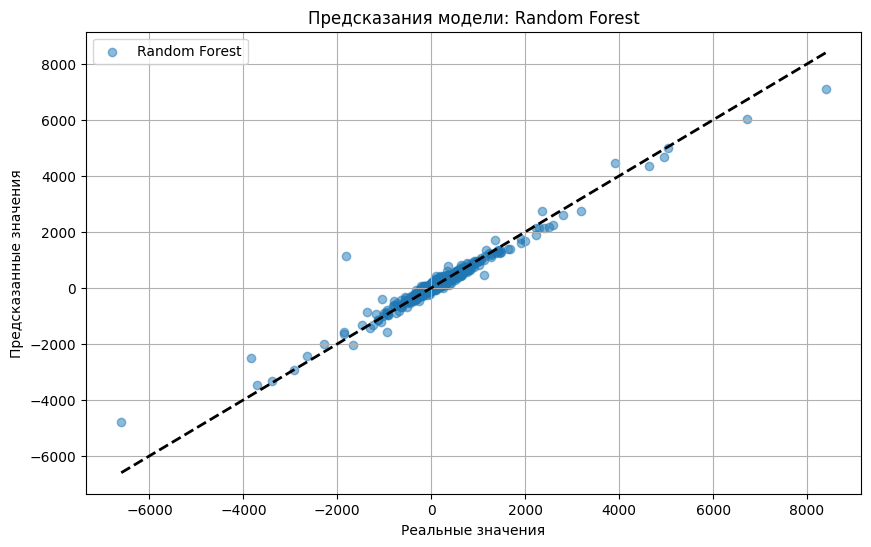

2025-03-06 22:15:49,936 - INFO - График для Random Forest сохранен.


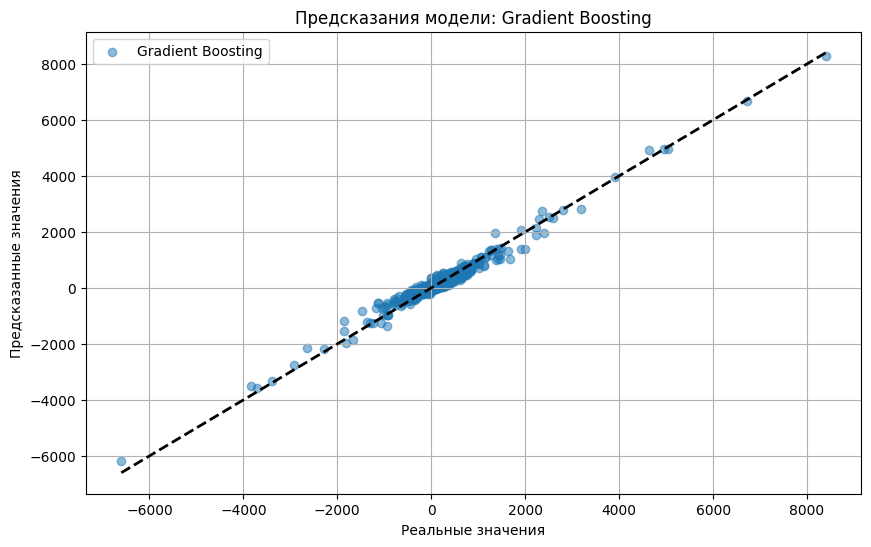

2025-03-06 22:15:52,344 - INFO - График для Gradient Boosting сохранен.


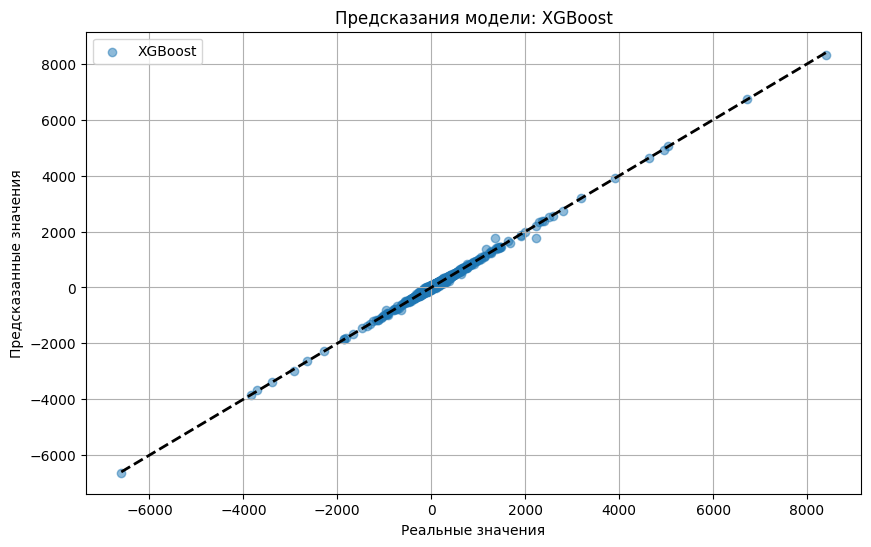

2025-03-06 22:15:54,737 - INFO - График для XGBoost сохранен.


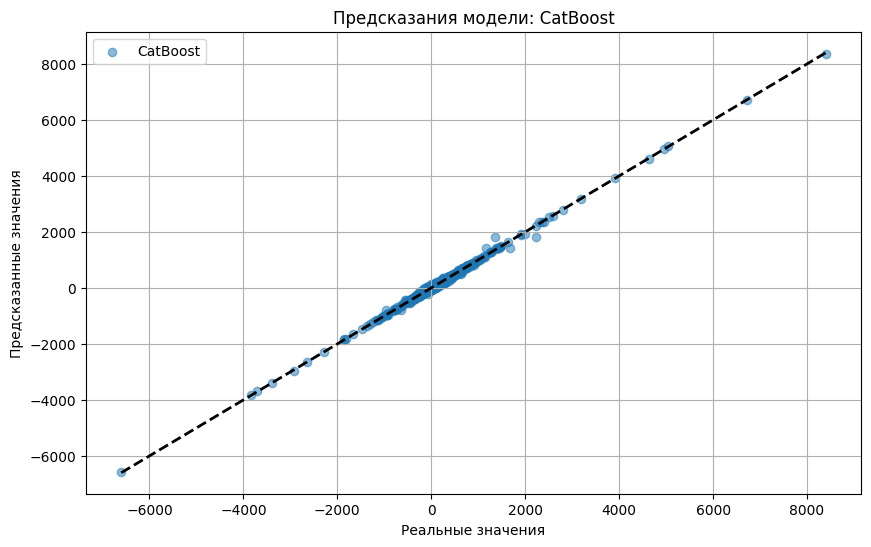

2025-03-06 22:15:57,122 - INFO - График для CatBoost сохранен.
2025-03-06 22:15:57,124 - INFO - Построение общего графика...


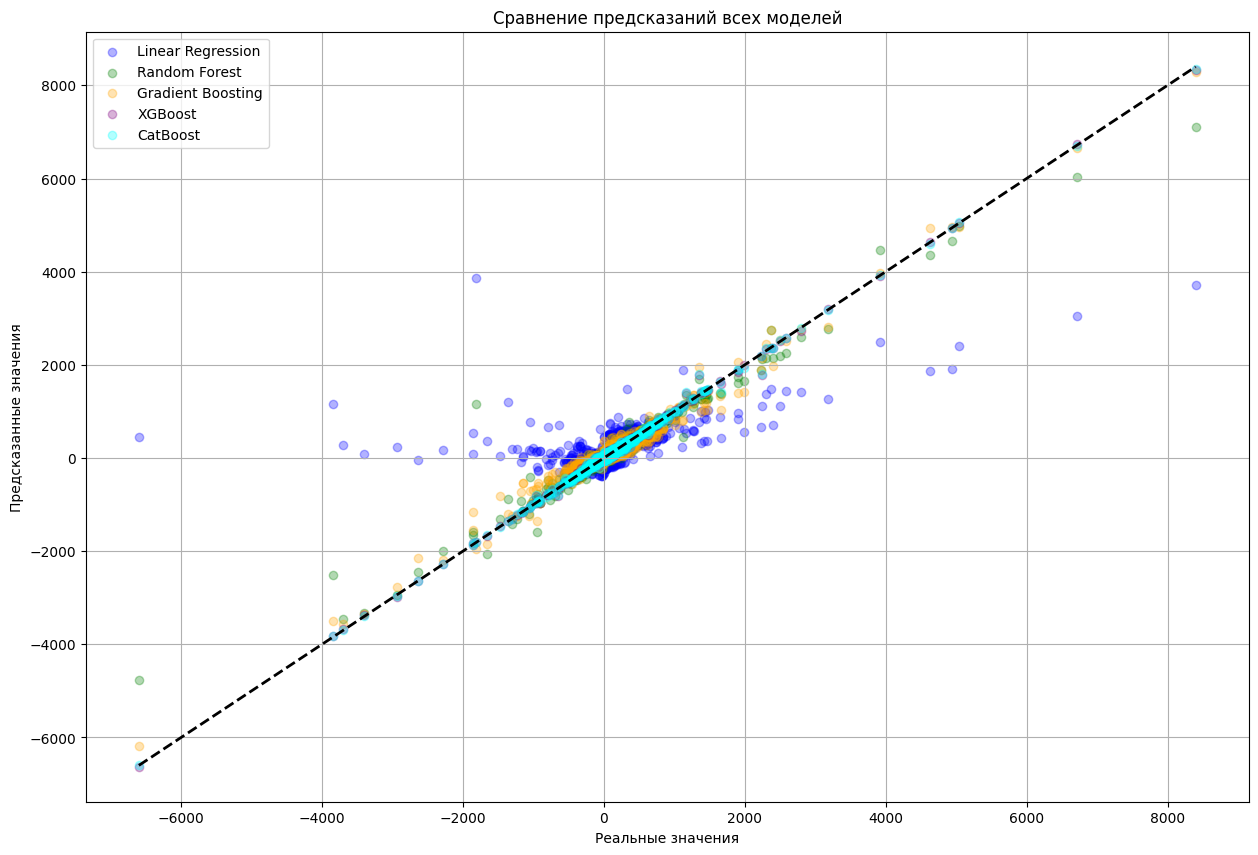

2025-03-06 22:16:03,467 - INFO - Общий график сохранен.
2025-03-06 22:16:03,469 - INFO - Построение графика лучшей модели...


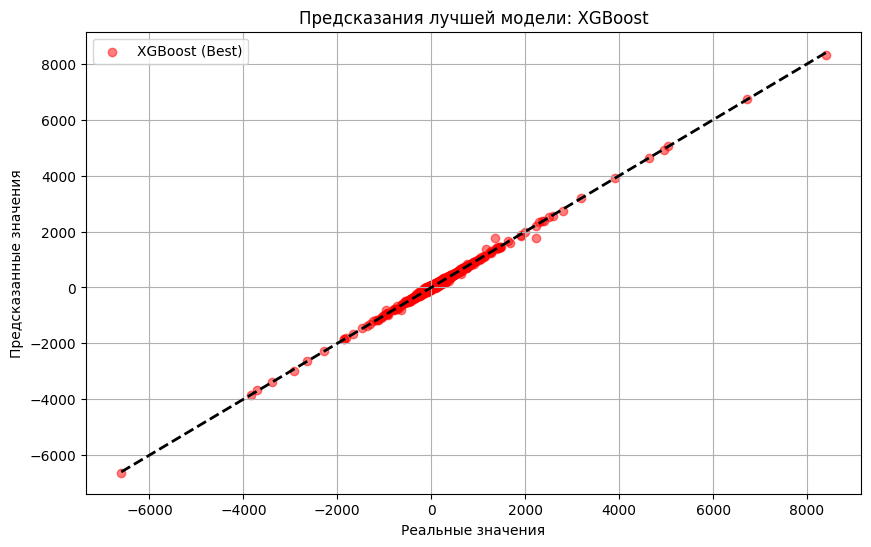

2025-03-06 22:16:06,830 - INFO - График лучшей модели сохранен.


In [7]:
import joblib
import matplotlib.pyplot as plt
import logging
import os

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_model(model_name):
    """Загрузка модели из файла."""
    filename = f"{model_name.replace(' ', '_').lower()}_model.joblib"
    if not os.path.exists(filename):
        logging.error(f"Файл модели {filename} не найден!")
        return None
    return joblib.load(filename)

# Загрузка данных и метрик
try:
    data = joblib.load('preprocessed_data.joblib')
    X, y = data['X'], data['y']
    results = joblib.load('model_results.joblib')
    best_model_name = max(results, key=lambda k: results[k]['R²'])
    logging.info("Данные и метрики успешно загружены.")
except Exception as e:
    logging.error(f"Ошибка загрузки данных: {str(e)}")
    exit()

# Список всех моделей
models = [
    "Linear Regression",
    "Random Forest",
    "Gradient Boosting",
    "XGBoost",
    "CatBoost"
]

# --------------------------------------------
# 1. Отдельные графики для каждой модели
# --------------------------------------------
logging.info("Построение отдельных графиков для каждой модели...")
for model_name in models:
    model = load_model(model_name)
    if model is None:
        continue
    
    y_pred = model.predict(X)
    
    # Создание фигуры
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5, label=model_name)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания модели: {model_name}')
    plt.legend()
    plt.grid(True)
    
    # Отображение графика
    plt.show(block=False)  # Не блокирует выполнение кода
    plt.pause(2)  # Пауза для просмотра (в секундах)
    
    # Сохранение графика
    plt.savefig(f"{model_name.replace(' ', '_').lower()}_predictions.png")
    plt.close()
    logging.info(f"График для {model_name} сохранен.")

# --------------------------------------------
# 2. Общий график всех моделей
# --------------------------------------------
logging.info("Построение общего графика...")
plt.figure(figsize=(15, 10))
colors = ['blue', 'green', 'orange', 'purple', 'cyan']

for idx, model_name in enumerate(models):
    model = load_model(model_name)
    if model is None:
        continue
    
    y_pred = model.predict(X)
    plt.scatter(y, y_pred, alpha=0.3, color=colors[idx], label=model_name)

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний всех моделей')
plt.legend()
plt.grid(True)

# Отображение и сохранение
plt.show(block=False)
plt.pause(5)  # Увеличенная пауза для общего графика
plt.savefig("all_models_predictions.png")
plt.close()
logging.info("Общий график сохранен.")

# --------------------------------------------
# 3. График лучшей модели
# --------------------------------------------
logging.info("Построение графика лучшей модели...")
best_model = load_model(best_model_name)
if best_model is not None:
    y_pred = best_model.predict(X)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5, color='red', label=f'{best_model_name} (Best)')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания лучшей модели: {best_model_name}')
    plt.legend()
    plt.grid(True)
    
    plt.show(block=False)
    plt.pause(3)
    plt.savefig("best_model_predictions.png")
    plt.close()
    logging.info("График лучшей модели сохранен.")
else:
    logging.error("Не удалось загрузить лучшую модель!")

2025-03-06 22:16:06,847 - INFO - Лучшая модель успешно загружена.


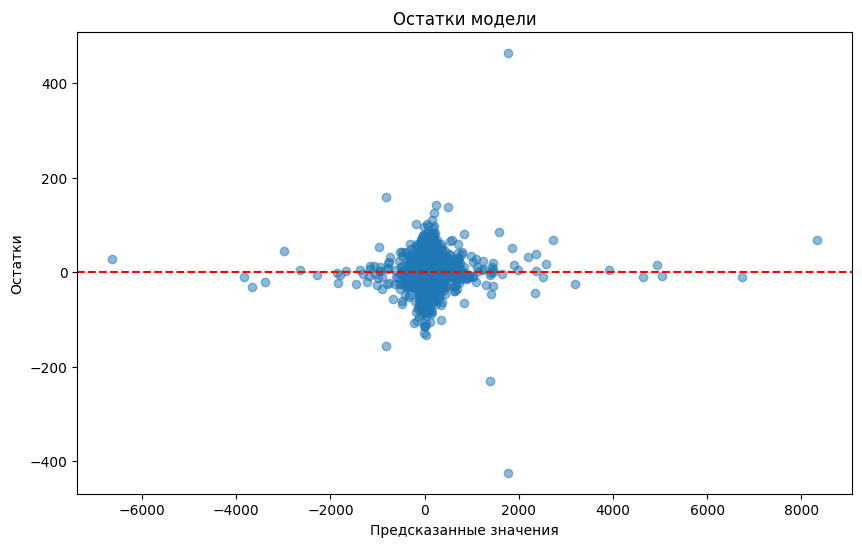

2025-03-06 22:16:07,076 - INFO - График остатков построен.


In [8]:
import joblib
import matplotlib.pyplot as plt
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка лучшей модели
best_model = joblib.load('best_model.joblib')
logging.info("Лучшая модель успешно загружена.")

# Загрузка предобработанных данных
data = joblib.load('preprocessed_data.joblib')
X = data['X']
y = data['y']

# Предсказания модели
y_pred = best_model.predict(X)

# Остатки
residuals = y - y_pred

# Визуализация остатков
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки модели')
plt.show()
logging.info("График остатков построен.")